In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torch.optim as optim
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [30]:
class_labels = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 tons",
    11: "Right-of-way at next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 tons"
}


In [2]:
print(torch.__version__)

2.7.1+cu128


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # or 32x32 if you want faster training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root='kaggle_datasets/data/train', transform=transform)
test_dataset = ImageFolder(root='kaggle_datasets/data/test', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
for X, y in train_loader:
    print(X.shape,y.shape)
    break

torch.Size([64, 3, 64, 64]) torch.Size([64])


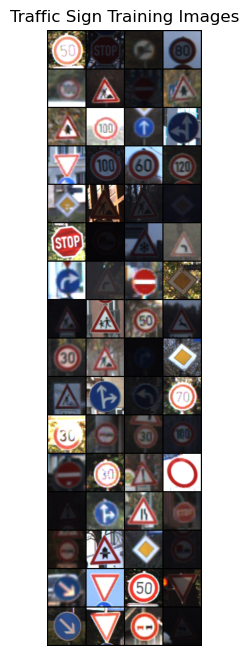

In [7]:
images, labels = next(iter(train_loader))

# Undo normalization for visualization
images = images * 0.5 + 0.5  # unnormalize to [0, 1]

# Create a grid of 16 images (4x4)
img_grid = torchvision.utils.make_grid(images, nrow=4)

# Plot
plt.figure(figsize=(16, 8))
plt.imshow(img_grid.permute(1, 2, 0))  # [C, H, W] → [H, W, C]
plt.title("Traffic Sign Training Images")
plt.axis("off")
plt.show()

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()

        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1) #[16,64,64]
        self.pool = nn.MaxPool2d(2,2) # [16,32,32]
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1) #[32,32,32]
        self.pool = nn.MaxPool2d(2,2) # [32,16,16]
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1) #[64,16,16]
        self.pool = nn.MaxPool2d(2,2) # [64,8,8]
        self.fc1 = nn.Linear(64*8*8,128)
        self.fc2 = nn.Linear(128,43)



    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=43, bias=True)
)

In [9]:
#set loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
for epoch in range(5):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # ✅ Send to GPU

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.2017
Epoch 2, Loss: 0.1404
Epoch 3, Loss: 0.0618
Epoch 4, Loss: 0.0421
Epoch 5, Loss: 0.0274


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 92.79%


In [34]:
import random
import matplotlib.pyplot as plt

def show_predictions(model, dataset, device, n=9):
    model.eval()
    indices = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(12, 12))

    for i, idx in enumerate(indices):
        x, y = dataset[idx]  # x: image tensor, y: true label (int)
        x_input = x.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(x_input)
            predicted_label = output.argmax(1).item()

        # Unnormalize image
        img = x * 0.5 + 0.5
        img = img.permute(1, 2, 0).cpu().numpy()

        # Use class_labels to get readable names
        pred_name = class_labels[predicted_label]
        true_name = class_labels[y]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


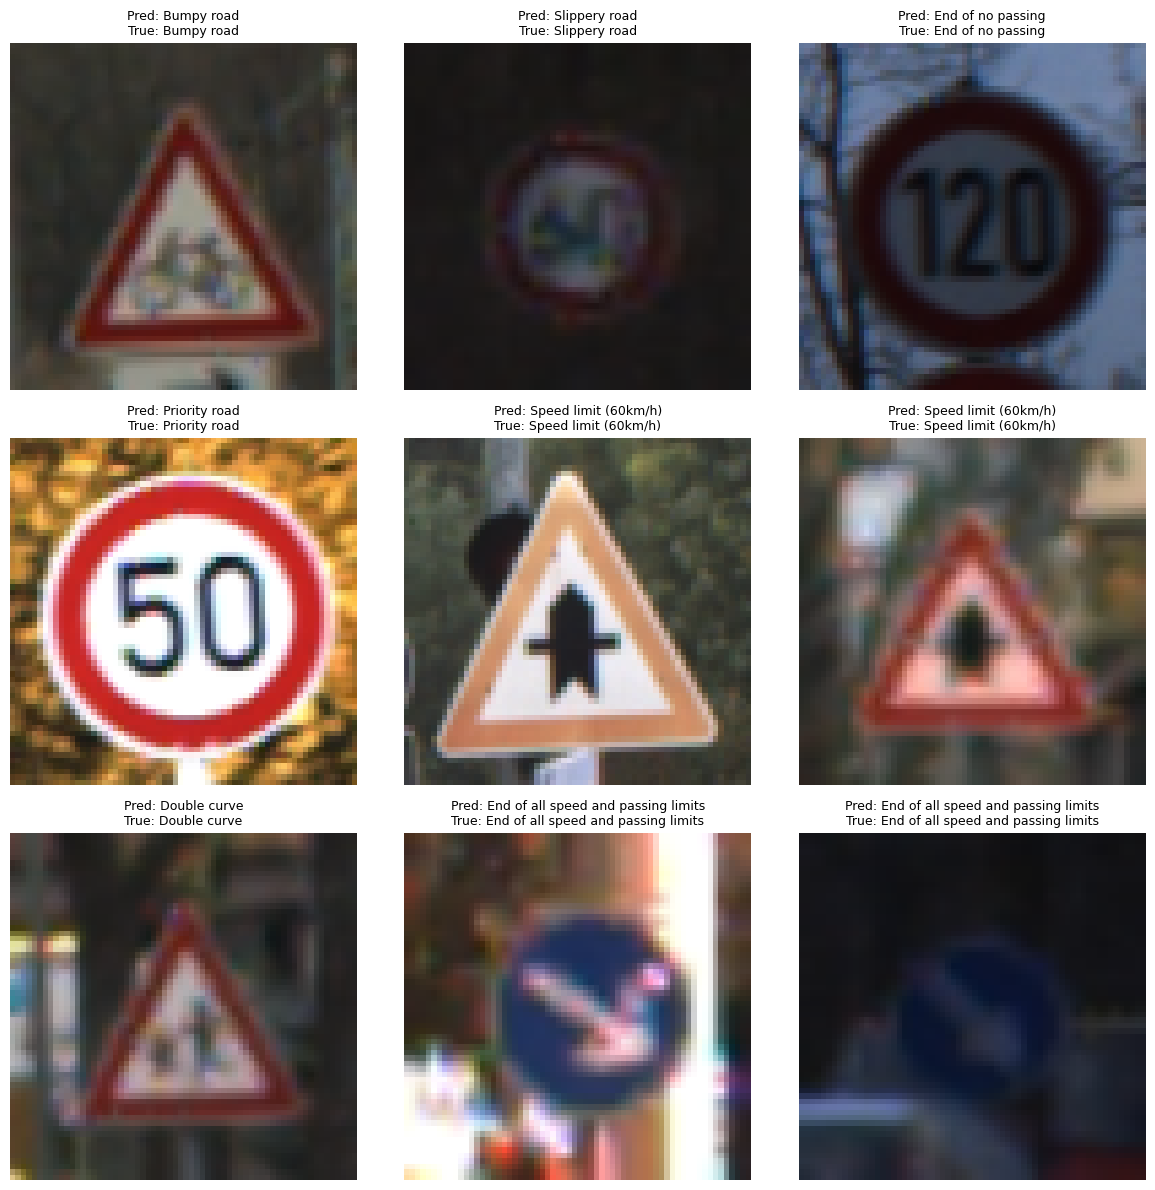

In [36]:
show_predictions(model, train_dataset, device)

In [14]:
torch.save(model.state_dict(), "../artifacts/model.pth")